In [2]:
import ee
import geemap
import pandas as pd
import altair as alt
from scipy.stats import gaussian_kde
import numpy as np
ee.Initialize()


In [3]:
def toPoints(feat):
  pt = ee.Feature(ee.Geometry.Point([feat.get('long'), feat.get('lat')])).copyProperties(feat)
  return pt

def att_editor(feat:ee.Feature, l:ee.List):
    def bp_rounder(prop:ee.String):
        decimal = ee.Number.parse(ee.Number(feat.get(prop)).format("%.4f")) #// get one more decimal place than needed
        rounded = decimal.multiply(1000).round().divide(1000)
        diff = ee.Number(feat.get('burnprob_c')).subtract(rounded)
        return feat.set(prop.cat('round'), rounded, ee.String(prop).cat('_diff'), diff)
    l.map(bp_rounder)

def sample_image(image, region, numPixels, scale=30, seed=1337, geometries=False ):
    samples = image.sample(**{'region':region,
                          'scale':scale,
                          'numPixels':numPixels,
                          'seed':seed,
                          'tileScale':6,
                          'geometries':geometries})
    return samples

def get_samples_df(samples:ee.FeatureCollection, properties:list,):
    # Arrange the sample as a list of lists.
    samp_dict = samples.reduceColumns(ee.Reducer.toList().repeat(len(properties)), properties)
    samp_list = ee.List(samp_dict.get('list'))

    # Save server-side ee.List as a client-side Python list.
    samp_data = samp_list.getInfo()
    df_source = {e : samp_data[i] for i,e in enumerate(properties)}
    source = pd.DataFrame(df_source)
    return source

def default_chart(df,x,y,title,subtitle=""):
    # Calculate the point density
    xy = np.vstack([df[x],df[y]])
    df['z'] = gaussian_kde(xy)(xy)
    
    chart = alt.Chart(df).mark_circle(size=20).encode(
        alt.X(f'{x}:Q'),
        alt.Y(f'{y}:Q'),
        alt.Color('z:Q', scale=alt.Scale(scheme='inferno')),##alt.value("#a83238"),
        #opacity=alt.value(0.6),
        ).properties(
            title={'text':title,
                  'subtitle':subtitle}
        ).configure_title(
            fontSize=20,
            font='Roboto',
            align='left',
            color='black',
        )
    return chart



#sampled_sub = sampled.limit(5000)

In [4]:
# import os
# bp_imgs = os.popen(f"earthengine ls projects/pyregence-ee/assets/lucas/tensorflow/").read().split('\n')
# for img in bp_imgs:
#     print(img)

In [5]:
bp1 = ee.Image("projects/pyregence-ee/assets/lucas/tensorflow/BPpredictions_linear_huber_GrassValley").rename("BP_linear_huber_v1").multiply(1000).round().divide(1000)
bp2 = ee.Image("projects/pyregence-ee/assets/lucas/tensorflow/vgg16unet_model_jjd_mae_sigmoid_v5_ESTIMATOR_grass_valley").rename("BP_sigmoid_mae_v5").multiply(1000).round().divide(1000)
bp3 = ee.Image("projects/pyregence-ee/assets/lucas/tensorflow/vgg16unet_model_kdw_linear_huber_v7_rev2_ESTIMATOR_grass_valley").rename("BP_linear_huber_v7").multiply(1000).round().divide(1000)
bp4 = ee.Image("projects/pyregence-ee/assets/lucas/tensorflow/vgg16unet_model_kdw_sigmoid_mae_v7_rev2_ESTIMATOR_bbox0").rename("BP_sigmoid_mae_v7_rev2").multiply(1000).round().divide(1000)

bp_stack = bp1.addBands(bp2).addBands(bp3).addBands(bp4)

# convert geometries of parcels FC to their centroid points retaining all properties
parcels = ee.FeatureCollection("projects/pyregence-ee/assets/lucas/tensorflow/grass_valley_parcels_forQA")
pts = parcels.map(toPoints)

#sample all BP bands at the centroid pts
sampled = bp_stack.sampleRegions(pts, None, 30, 'EPSG:4269', 1, False)
#print(sampled.first().getInfo())

properties = sampled.first().propertyNames().getInfo()
df_samples = get_samples_df(sampled, properties)
#print(df_samples.head(5))

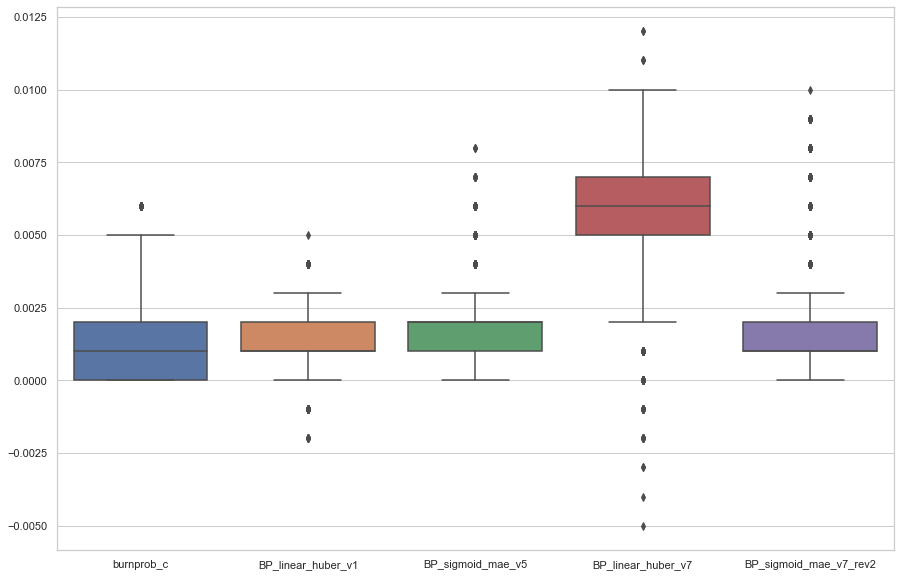

In [8]:
import seaborn as sns
elements = ['burnprob_c', 'BP_linear_huber_v1', 'BP_sigmoid_mae_v5', 'BP_linear_huber_v7', 'BP_sigmoid_mae_v7_rev2']
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=df_samples[elements], orient="v")

sns.set(rc = {'figure.figsize':(12,10)})


In [10]:
# generate stats on how many parcels had a difference that would amount to firefactor change and export those to a spreadsheet or something
linear_huber_v1_diff = df_samples['BP_linear_huber_v1'] - df_samples['burnprob_c']
# print(linear_huber_v1_diff)

print(elements[1:])
for col in elements[1:]:
    new_diff_col = df_samples[col] - df_samples['burnprob_c']
    new_diff_colName = col + '_diff'
    
    new_avg_col = (df_samples[col] + df_samples["burnprob_f"])/2
    new_avg_colName = col + "_newCurFutAvg"
    df_samples[new_diff_colName], df_samples[new_avg_colName] = [new_diff_col, new_avg_col]

df_samples['existing_bp_avg'] = (df_samples['burnprob_c'] + df_samples['burnprob_f'])/2
df_samples

# firefactor breakpoints based on min-max BP current/future average
#pd.cut(df_samples['existing_bp_avg'], bins=[0,0.,7,11], right=True, labels=False)+1

['BP_linear_huber_v1', 'BP_sigmoid_mae_v5', 'BP_linear_huber_v7', 'BP_sigmoid_mae_v7_rev2']


,firefactor,burnprob_c,parcel_id,burnprob_f,long,lat,_uid_,BP_linear_huber_v1,BP_sigmoid_mae_v5,BP_linear_huber_v7,...,system:index,BP_linear_huber_v1_diff,BP_linear_huber_v1_newCurFutAvg,BP_sigmoid_mae_v5_diff,BP_sigmoid_mae_v5_newCurFutAvg,BP_linear_huber_v7_diff,BP_linear_huber_v7_newCurFutAvg,BP_sigmoid_mae_v7_rev2_diff,BP_sigmoid_mae_v7_rev2_newCurFutAvg,existing_bp_avg
0,2,0.000,611939117,0.000,-120.90226,39.25826,18030,0.001,0.001,0.004,...,00000000000000000007_0,0.001,0.0005,0.001,0.0005,0.004,0.0020,0.001,0.0005,0.0000
1,2,0.000,608156184,0.000,-120.90222,39.25667,18040,0.002,0.001,0.004,...,00000000000000000011_0,0.002,0.0010,0.001,0.0005,0.004,0.0020,0.002,0.0010,0.0000
2,2,0.000,611939101,0.000,-120.90456,39.25843,18049,0.002,0.001,0.005,...,0000000000000000001a_0,0.002,0.0010,0.001,0.0005,0.005,0.0025,0.002,0.0010,0.0000
3,2,0.000,608156171,0.000,-120.90387,39.26046,18087,0.003,0.002,0.007,...,00000000000000000040_0,0.003,0.0015,0.002,0.0010,0.007,0.0035,0.001,0.0005,0.0000
4,2,0.000,608128297,0.000,-121.06462,39.23555,18465,0.002,0.002,0.006,...,000000000000000001b7_0,0.002,0.0010,0.002,0.0010,0.006,0.0030,0.001,0.0005,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14375,8,0.004,608127088,0.011,-121.07915,39.24382,14869,0.002,0.003,0.007,...,00000000000000006de8_0,-0.002,0.0065,-0.001,0.0070,0.003,0.0090,0.001,0.0080,0.0075
14376,8,0.004,608127062,0.011,-121.07805,39.24570,14881,0.001,0.004,0.007,...,00000000000000006df4_0,-0.003,0.0060,0.000,0.0075,0.003,0.0090,0.001,0.0080,0.0075
14377,8,0.004,608127066,0.011,-121.07707,39.24480,14886,0.003,0.003,0.007,...,00000000000000006df9_0,-0.001,0.0070,-0.001,0.0070,0.003,0.0090,0.001,0.0080,0.0075
14378,8,0.004,611930923,0.011,-121.07851,39.24459,14902,0.001,0.003,0.007,...,00000000000000006e09_0,-0.003,0.0060,-0.001,0.0070,0.003,0.0090,0.001,0.0080,0.0075


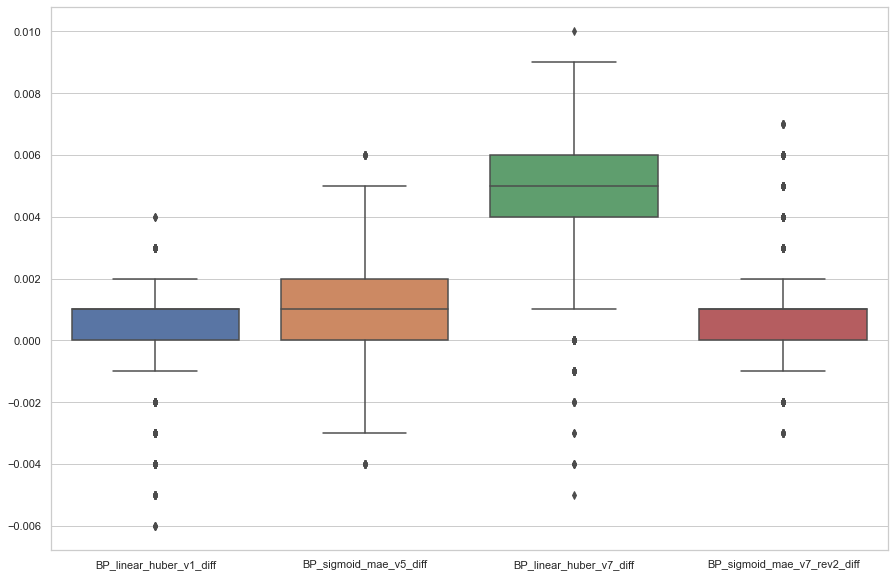

In [13]:
elements1 = ['BP_linear_huber_v1_diff', 'BP_sigmoid_mae_v5_diff', 'BP_linear_huber_v7_diff', 'BP_sigmoid_mae_v7_rev2_diff']
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=df_samples[elements1], orient="v")

sns.set(rc = {'figure.figsize':(18,10)})

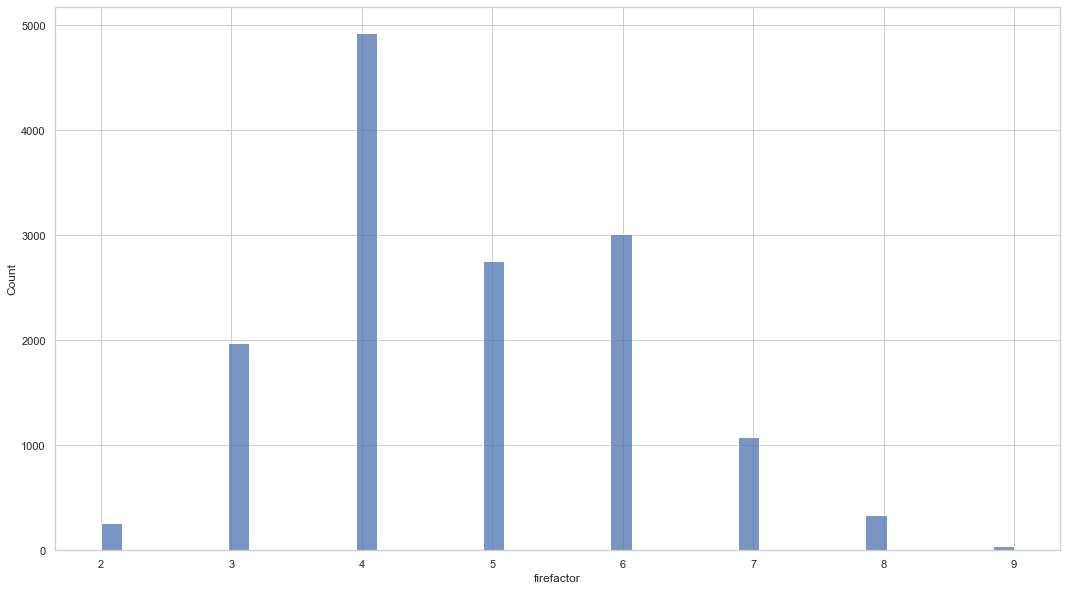

In [14]:
# barplot of firefactors
sns.set_theme(style="whitegrid")
ax = sns.histplot(data=df_samples["firefactor"])